In [4]:
import numpy as np
import pandas as pd
import networkx
import matplotlib.pyplot as plt
import re

In [2]:
twitter_data = pd.read_csv(r"data/scored_tweets_total.csv")

In [3]:
twitter_data

,Stock,Datetime,user.screen_name,id_str,text,Sentiment,Known_Pumper,Price_Region,Inflection_Point
0,AXTG,2021-03-25 17:50:13+00:00,UCitnow,1375142994920271872a,#RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EV...,0,0,1.0,NaN
1,AXTG,2021-03-25 17:50:48+00:00,UCitnow,1375143141058080768a,RT @UCitnow: #RT @ldev117: RT @UCitnow: @Short...,0,0,1.0,NaN
2,AXTG,2021-03-25 18:47:48+00:00,Rad7RR,1375157484063584261a,$AXTG Big OTC % Gainer!🚀🚀🚀,1,0,1.0,NaN
3,AXTG,2021-03-25 20:02:03+00:00,GetScanz,1375176172099747845a,Today’s Top Penny Stock Gainers\n\n$LTTGF $AXT...,1,0,1.0,NaN
4,AXTG,2021-03-25 20:02:48+00:00,christinebarnum,1375176361560604679a,RT @GetScanz: Today’s Top Penny Stock Gainers\...,1,0,1.0,NaN
...,...,...,...,...,...,...,...,...,...
10071,EEENF,2021-04-09 01:00:55+00:00,TVTVentures,1380324815689539585a,Holding until at least summer $WDHR $EEENF $PH...,1,0,0.0,NaN
10072,EEENF,2021-04-09 01:06:47+00:00,BuyLowSell420,1380326289735708672a,@TheFlyingScotto Yep well now that the bushy a...,-1,0,0.0,NaN
10073,EEENF,2021-04-09 01:06:56+00:00,superlars34,1380326328524623873a,$VPER 🚀 $PHIL $IMTL $ABML $UATG $SFOR $LTNC $I...,1,0,0.0,NaN
10074,EEENF,2021-04-09 01:07:55+00:00,DaveWhitman12,1380326575414120448a,RT @jasontrade99: $EEENF 💰💰💰💰🤮🤮🤮🔥🔥🔥🔥🚀🚀🚀🚀🚀🚀,1,0,0.0,NaN


## Extract Pumper Retweet

In [8]:
def extract_twitter_handles_from_dataframe(df):
  """
  Extracts Twitter handles from a pandas DataFrame, where usernames are in
  the 'user.screen_name' column and tweet text is in the 'text' column.

  Args:
    df: The pandas DataFrame.

  Returns:
    A pandas DataFrame with a new column 'mentioned_handles' containing lists of
    extracted Twitter handles.
  """

  def extract_handles(text):
    if isinstance(text, str): #handle nan cases
      pattern = r"@([a-zA-Z0-9_]+)"
      handles = re.findall(pattern, text)
      if len(handles) == 0:
        return None
      return handles
    else:
      return None

  df['mentioned_handles'] = df['text'].apply(extract_handles)
  return df

twitter_df_with_handles = extract_twitter_handles_from_dataframe(twitter_data)

  Stock                   Datetime user.screen_name                id_str  \
0  AXTG  2021-03-25 17:50:13+00:00          UCitnow  1375142994920271872a   
1  AXTG  2021-03-25 17:50:48+00:00          UCitnow  1375143141058080768a   
2  AXTG  2021-03-25 18:47:48+00:00           Rad7RR  1375157484063584261a   
3  AXTG  2021-03-25 20:02:03+00:00         GetScanz  1375176172099747845a   
4  AXTG  2021-03-25 20:02:48+00:00  christinebarnum  1375176361560604679a   

                                                text  Sentiment  Known_Pumper  \
0  #RT @ldev117: RT @UCitnow: @ShortSqueezed1 @EV...          0             0   
1  RT @UCitnow: #RT @ldev117: RT @UCitnow: @Short...          0             0   
2                         $AXTG Big OTC % Gainer!🚀🚀🚀          1             0   
3  Today’s Top Penny Stock Gainers\n\n$LTTGF $AXT...          1             0   
4  RT @GetScanz: Today’s Top Penny Stock Gainers\...          1             0   

   Price_Region  Inflection_Point  \
0           1

In [29]:
twitter_df_with_handles.columns

Index(['Stock', 'Datetime', 'user.screen_name', 'id_str', 'text', 'Sentiment',
       'Known_Pumper', 'Price_Region', 'Inflection_Point',
       'mentioned_handles'],
      dtype='object')

In [39]:
rt_edge_list = {
  "Source": [],
  "Target": []
}
known_pumpers = {}
for indx in range(twitter_df_with_handles.shape[0]):
  _row = twitter_df_with_handles.loc[indx]
  source = _row["user.screen_name"]
  targets = _row["mentioned_handles"]
  known_pumper = _row["Known_Pumper"]
  if not targets:
    continue
  if known_pumper:
    known_pumpers[source] = True
  for target in targets:
    if source == target:
      continue
    rt_edge_list["Source"].append(source)
    rt_edge_list["Target"].append(target)
    if target not in known_pumpers:
      known_pumpers[target] = False

In [40]:
print(rt_edge_list["Source"][:5])
print(rt_edge_list["Target"][:5])

['UCitnow', 'UCitnow', 'UCitnow', 'UCitnow', 'UCitnow']
['ldev117', 'ShortSqueezed1', 'EVO9MRPLEASE', 'ldev117', 'ShortSqueezed1']


In [44]:
import networkx as nx
import pandas as pd

# Example "Known_Pumper" data (replace with your actual data)
pumper_data = pd.Series(known_pumpers)

# Create a directed graph
G = nx.from_pandas_edgelist(rt_edge_list, source='Source', target='Target')

# Add the 'is_pumper' attribute to each node
for node in G.nodes():
    if node in pumper_data:
        G.nodes[node]['is_pumper'] = pumper_data[node]
    else:
        G.nodes[node]['is_pumper'] = False #Or any default value that you want.

#Example of how to check if a node is a pumper.
print(G.nodes['UCitnow']['is_pumper'])

False


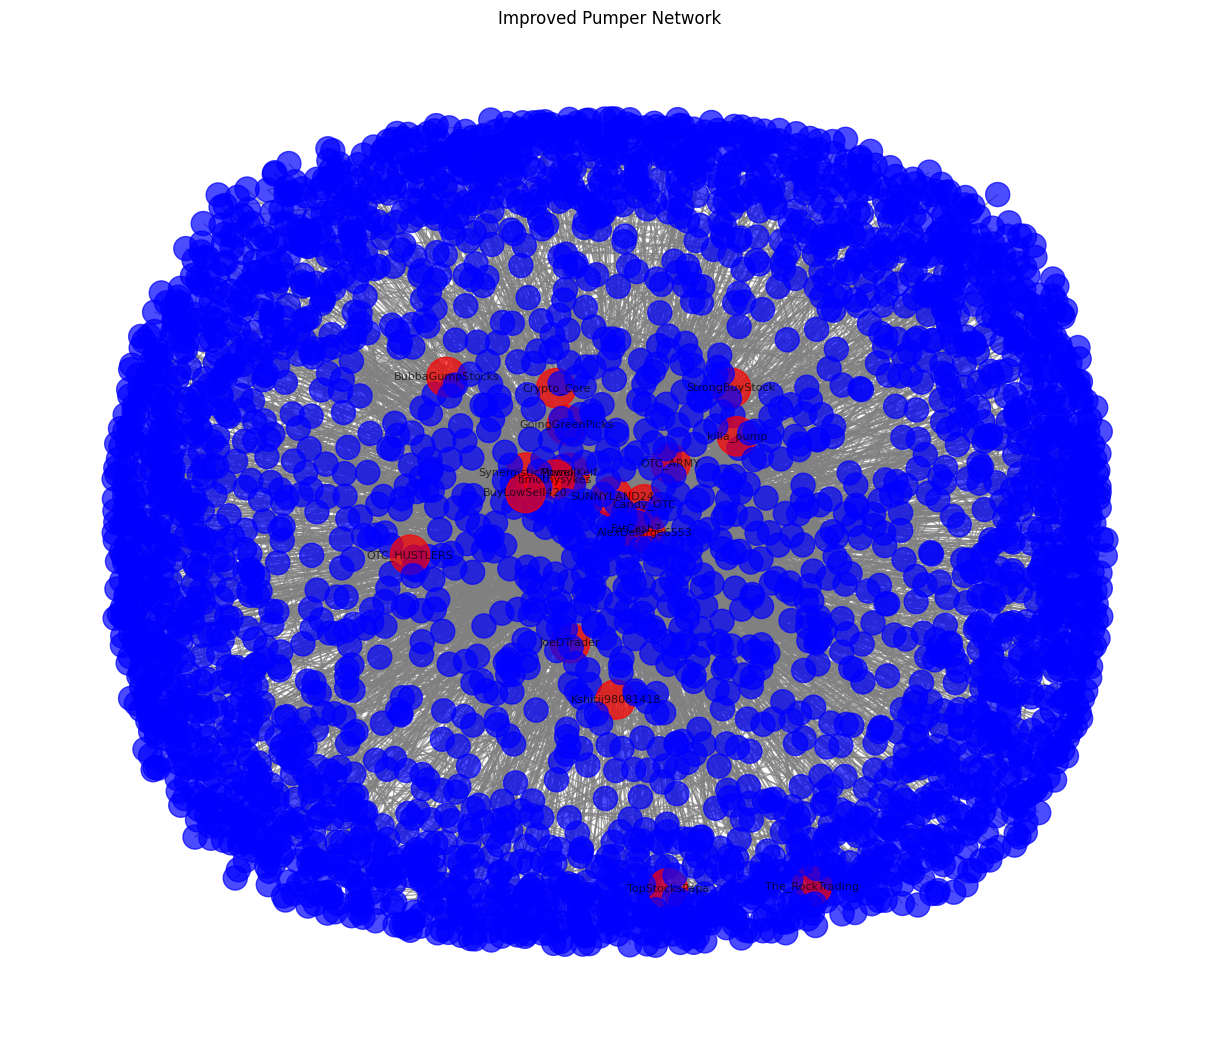

In [48]:
def plot_pumper_graph_from_existing(graph, pumper_data):
    """
    Plots an improved pumper network graph with force-directed layout,
    node coloring, and label filtering.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.
    """

    # 1. Force-Directed Layout
    pos = nx.spring_layout(graph, k=0.15, iterations=20)  # Adjust k and iterations as needed

    # 2. Node Coloring and Sizing
    node_colors = []
    node_sizes = []
    for node in graph.nodes():
        if node in pumper_data and pumper_data[node]:
            node_colors.append('red')  # Pumper nodes are red
            node_sizes.append(800) #Make pumpers larger.
        else:
            node_colors.append('blue') # Non-pumper nodes are blue
            node_sizes.append(300)

    # 3. Label Filtering
    labels = {}
    for node in graph.nodes():
        if node in pumper_data and pumper_data[node]:
            labels[node] = node  # Show labels only for pumpers

    # 4. Visualization
    plt.figure(figsize=(12, 10))
    nx.draw(graph, pos, with_labels=True, labels=labels,
            node_color=node_colors, node_size=node_sizes,
            font_size=8, edge_color='gray', alpha=0.7)
    plt.title("Improved Pumper Network")
    plt.show()
    
plot_pumper_graph_from_existing(G, pumper_data)

In [51]:
def calculate_average_centrality(graph, pumper_data):
    """
    Calculates the average centrality scores for pumpers and non-pumpers.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.

    Returns:
        A dictionary containing the average centrality scores.
    """

    pumper_nodes = [node for node, is_pumper in pumper_data.items() if is_pumper]
    non_pumper_nodes = [node for node, is_pumper in pumper_data.items() if not is_pumper]

    # Calculate Centrality Measures
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

    # Average Centrality for Pumpers
    avg_pumper_degree = np.mean([degree_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_betweenness = np.mean([betweenness_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0

    # Average Centrality for Non-Pumpers
    avg_non_pumper_degree = np.mean([degree_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_betweenness = np.mean([betweenness_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0

    return {
        'avg_pumper_degree': avg_pumper_degree,
        'avg_pumper_betweenness': avg_pumper_betweenness,
        'avg_pumper_eigenvector': avg_pumper_eigenvector,
        'avg_non_pumper_degree': avg_non_pumper_degree,
        'avg_non_pumper_betweenness': avg_non_pumper_betweenness,
        'avg_non_pumper_eigenvector': avg_non_pumper_eigenvector,
    }


average_centralities = calculate_average_centrality(G, pumper_data)

# Print the average centrality scores
for metric, value in average_centralities.items():
    print(f"{metric}: {value}")

avg_pumper_degree: 0.0074353063411149705
avg_pumper_betweenness: 0.007845397776172148
avg_pumper_eigenvector: 0.02565403810786402
avg_non_pumper_degree: 0.0018547718299854394
avg_non_pumper_betweenness: 0.001174307754541526
avg_non_pumper_eigenvector: 0.01015554991691486


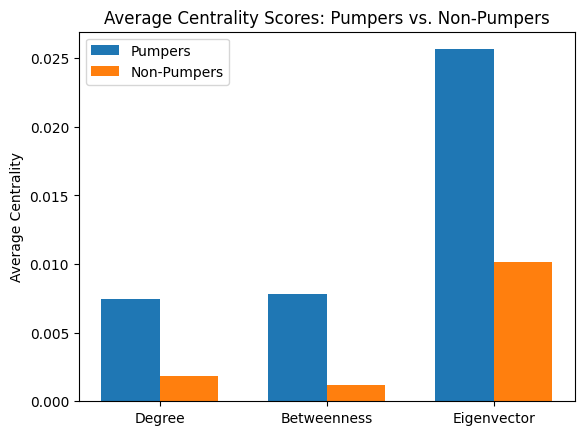


Statistical Significance (T-Tests):
Degree: t = 4.527, p = 6.650e-06
Betweenness: t = 5.034, p = 5.622e-07
Eigenvector: t = 2.582, p = 9.956e-03


In [52]:
from scipy import stats

def visualize_and_test_centrality(graph, pumper_data):
    """
    Visualizes and performs statistical tests on average centrality scores.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.
    """

    pumper_nodes = [node for node, is_pumper in pumper_data.items() if is_pumper]
    non_pumper_nodes = [node for node, is_pumper in pumper_data.items() if not is_pumper]

    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

    avg_pumper_degree = np.mean([degree_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_betweenness = np.mean([betweenness_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0
    avg_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in pumper_nodes]) if pumper_nodes else 0

    avg_non_pumper_degree = np.mean([degree_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_betweenness = np.mean([betweenness_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0
    avg_non_pumper_eigenvector = np.mean([eigenvector_centrality[node] for node in non_pumper_nodes]) if non_pumper_nodes else 0

    # 1. Visualization (Bar Charts)
    centrality_types = ['Degree', 'Betweenness', 'Eigenvector']
    pumper_avgs = [avg_pumper_degree, avg_pumper_betweenness, avg_pumper_eigenvector]
    non_pumper_avgs = [avg_non_pumper_degree, avg_non_pumper_betweenness, avg_non_pumper_eigenvector]

    x = np.arange(len(centrality_types))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, pumper_avgs, width, label='Pumpers')
    rects2 = ax.bar(x + width/2, non_pumper_avgs, width, label='Non-Pumpers')

    ax.set_ylabel('Average Centrality')
    ax.set_title('Average Centrality Scores: Pumpers vs. Non-Pumpers')
    ax.set_xticks(x)
    ax.set_xticklabels(centrality_types)
    ax.legend()

    plt.show()

    # 2. Statistical Significance (T-Tests)

    pumper_degree_values = [degree_centrality[node] for node in pumper_nodes]
    non_pumper_degree_values = [degree_centrality[node] for node in non_pumper_nodes]

    pumper_betweenness_values = [betweenness_centrality[node] for node in pumper_nodes]
    non_pumper_betweenness_values = [betweenness_centrality[node] for node in non_pumper_nodes]

    pumper_eigenvector_values = [eigenvector_centrality[node] for node in pumper_nodes]
    non_pumper_eigenvector_values = [eigenvector_centrality[node] for node in non_pumper_nodes]

    t_degree, p_degree = stats.ttest_ind(pumper_degree_values, non_pumper_degree_values)
    t_betweenness, p_betweenness = stats.ttest_ind(pumper_betweenness_values, non_pumper_betweenness_values)
    t_eigenvector, p_eigenvector = stats.ttest_ind(pumper_eigenvector_values, non_pumper_eigenvector_values)

    print("\nStatistical Significance (T-Tests):")
    print(f"Degree: t = {t_degree:.3f}, p = {p_degree:.3e}")
    print(f"Betweenness: t = {t_betweenness:.3f}, p = {p_betweenness:.3e}")
    print(f"Eigenvector: t = {t_eigenvector:.3f}, p = {p_eigenvector:.3e}")

visualize_and_test_centrality(G, pumper_data)

In [62]:
import networkx as nx
import pandas as pd
import pickle

def analyze_pumper_network(graph, pumper_data):
    """
    Analyzes the pumper network graph and calculates relevant metrics.

    Args:
        graph: The networkx graph.
        pumper_data: pandas Series or dictionary mapping node names to boolean values indicating pumper status.

    Returns:
        A dictionary containing the calculated metrics.
    """

    metrics = {}

    # 1. Centrality Measures
    degree_centrality = nx.degree_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=500)

    metrics['degree_centrality'] = degree_centrality
    metrics['betweenness_centrality'] = betweenness_centrality
    metrics['eigenvector_centrality'] = eigenvector_centrality

    # 2. Community Detection (Louvain Algorithm)
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(graph)
        metrics['communities'] = partition
    except ImportError:
        print("Community library not found. Install it with: pip install python-louvain")
        metrics['communities'] = None

    # 3. Graph Density and Transitivity
    metrics['density'] = nx.density(graph)
    try:
        metrics['transitivity'] = nx.transitivity(graph)
    except:
        metrics['transitivity'] = None

    # 4. Path Analysis (Example: Shortest Paths between Pumpers)
    pumper_nodes = [node for node, is_pumper in pumper_data.items() if is_pumper]
    shortest_paths = {}
    for pumper1 in pumper_nodes:
        for pumper2 in pumper_nodes:
            if pumper1 != pumper2:
                try:
                    shortest_paths[(pumper1, pumper2)] = nx.shortest_path(graph, pumper1, pumper2)
                except nx.NetworkXNoPath:
                    shortest_paths[(pumper1, pumper2)] = None
    metrics['shortest_paths'] = shortest_paths

    return metrics

# Example usage (replace with your actual graph and pumper data):
edge_list = pd.DataFrame({
    'Source': ['PumperA', 'PumperA', 'PumperB', 'PumperC', 'PumperD', 'PumperE', 'PumperF', 'PumperG'],
    'Target': ['PumperB', 'PumperC', 'PumperD', 'PumperA', 'PumperC', 'PumperA', 'PumperA', 'PumperF'],
})

G = nx.from_pandas_edgelist(edge_list, source='Source', target='Target')

pumper_data = pd.Series({
    'PumperA': True,
    'PumperC': True,
    'PumperE': True,
    'PumperF': True,
    'PumperB': False,
    'PumperD': False,
    'PumperG': False,
})

results = analyze_pumper_network(G, pumper_data)

# Save the results to a JSON file
filename = "pumper_network_analysis_results.pkl"

with open(filename, 'wb') as f:
    pickle.dump(results, f)  # indent=4 for pretty printing

print(f"Results saved to {filename}")

Results saved to pumper_network_analysis_results.pkl
